<a href="https://colab.research.google.com/github/jagr7/nlp-name-classifier/blob/master/name_classifier_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP From Scratch: Classifying Names with a Character Level RNN

# clone data

In [12]:
!git clone https://github.com/jaybirrd/nlp_name_classifier.git

fatal: destination path 'nlp_name_classifier' already exists and is not an empty directory.


# prepare the data

In [27]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def find_files(path):
  return glob.glob(path)

print(find_files('nlp_name_classifier/data/names/*.txt \n'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
  )

print(unicode_to_ascii('Ślusàrski \n'))

category_lines = {}
all_categories = []

def read_lines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicode_to_ascii(line) for line in lines]

#FUTURE DEV: put a popup here to select different datasets to analyze

for filename in find_files('nlp_name_classifier/data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = read_lines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines['Italian'][:5])

[]
Slusarski 
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# turn names into tensors

In [0]:
import torch

def letter_to_index(letter):
  return all_letters.find(letter)

#turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
  tensor = torch.zeros(1,n_letters)
  tensor[0][letter_to_index(letter)] = 1
  return tensor

#turn lines into a <line length x 1 x n_letters> Tensor
def line_to_tensor(line):
  tensor = torch.zeros(len(line),1,n_letters)
  for i, letter in enumerate(line):
    tensor[i][0][letter_to_index(letter)] = 1
    return tensor

print(line_to_tensor('James').size())
print(letter_to_tensor('J'))

# creating the network

In [15]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
      super(RNN, self).__init__()
      self.hidden_size = hidden_size
      self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
      self.i2o = nn.Linear(input_size + hidden_size, output_size)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      combined = torch.cat((input, hidden), dim=1)
      hidden = self.i2h(combined)
      output = self.softmax(self.i2o(combined))
      return output, hidden

    def init_hidden(self):
      return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

#FUTURE DEV: set up precomputing of tensors to further optimize

input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)


tensor([[-2.8877, -2.9861, -2.9419, -2.9846, -2.9021, -2.8357, -2.9020, -2.8921,
         -2.8602, -2.8444, -2.8863, -2.9321, -2.8148, -2.8425, -2.8796, -2.8332,
         -2.8869, -2.9353]], grad_fn=<LogSoftmaxBackward>) tensor([[ 0.0036,  0.1138, -0.0932,  0.0029,  0.0420,  0.0459,  0.0086,  0.0115,
         -0.0124,  0.0462,  0.0051,  0.0626,  0.0077, -0.0868,  0.0179,  0.0588,
          0.0463, -0.0310,  0.0558, -0.0251, -0.0628, -0.0728,  0.0628, -0.0274,
         -0.0265,  0.0405,  0.0073, -0.0087, -0.0378, -0.0429, -0.0407,  0.0023,
          0.0815,  0.0272, -0.0645,  0.0201,  0.0158,  0.0850,  0.0164, -0.0289,
         -0.0731,  0.0456, -0.1290, -0.0940,  0.0301,  0.0575, -0.0411, -0.0086,
          0.0853,  0.1004,  0.0846, -0.0643, -0.0025,  0.0945,  0.0712, -0.0056,
          0.0877,  0.0693,  0.0758, -0.1100,  0.0722,  0.0677, -0.1292, -0.0123,
         -0.0735,  0.0722, -0.1340, -0.1256,  0.0465,  0.0385,  0.0364, -0.0288,
          0.0845, -0.0273,  0.0232, -0.0487,  0.00

# preparing for training

In [22]:
import random

#netowrk interpreter - guess category based on network output
def category_guess(output):
  n, i = output.topk(1)
  category_index = i.item()
  return all_categories[category_index], category_index

print(category_guess(output))

#generate a training example
def random_select(x):
  return x[random.randint(0,len(x)-1)]

def random_category():
  r_cat = random_choice(all_categories)
  r_line = random_choice(category_lines[r_cat])
  category_tensor = torch.tensor([all_categories.index(r_cat)], dtype=torch.long)
  line_tensor = line_to_tensor(r_line)
  return r_cat, r_line, category_tensor, line_tensor

for i in range(10):
    r_cat, r_line, category_tensor, line_tensor = random_category()
    print('category =', r_cat, '/ line =', r_line)


('Dutch', 12)
category = German / line = Grosse
category = Portuguese / line = Lobo
category = Portuguese / line = Souza
category = Greek / line = Diakogeorgiou
category = Czech / line = Psik
category = Scottish / line = Reid
category = Dutch / line = Rooijakkers
category = Chinese / line = Kwei
category = Russian / line = Enin
category = Spanish / line = Echeverria


# training the network

In [24]:
#set up the training function
criterion = nn.NLLLoss()
learning_rate = .005

def train(category_tensor, line_tensor):
  hidden = rnn.init_hidden()
  rnn.zero_grad()
  
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(-learning_rate, p.grad.data)

  return output, loss.item()

#train the network
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1,n_iters+1):
  r_cat, r_line, category_tensor, line_tensor = random_category()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if i % plot_every ==0:
    guess, guess_index = category_guess(output)
    correct = '✓' if guess == r_cat else '✗ (%s)' % r_cat
    all_losses.append(current_loss/plot_every)
    current_loss = 0

    print('%d %d%% (%s) %.4f %s / %s %s' % (i, i/n_iters * 100, time_since(start), loss, r_line, guess, correct))

1000 1% (0m 1s) 2.8658 Do / Russian ✗ (Vietnamese)
2000 2% (0m 2s) 2.7346 Tsapaev / Russian ✓
3000 3% (0m 4s) 3.0029 Takekawa / Russian ✗ (Japanese)
4000 4% (0m 5s) 3.0040 Ruan / French ✗ (Chinese)
5000 5% (0m 7s) 3.1000 Hike / German ✗ (Japanese)
6000 6% (0m 8s) 2.4535 Mach / Korean ✗ (Vietnamese)
7000 7% (0m 9s) 2.9723 Fernandes / Italian ✗ (Portuguese)
8000 8% (0m 11s) 2.6343 Noschese / Russian ✗ (Italian)
9000 9% (0m 12s) 3.2282 Duong / Arabic ✗ (Vietnamese)
10000 10% (0m 13s) 2.7814 Niadh / Arabic ✗ (Irish)
11000 11% (0m 15s) 2.6139 Lennon / French ✗ (Irish)
12000 12% (0m 16s) 3.7536 Feld / Korean ✗ (German)
13000 13% (0m 17s) 2.7593 Akkeren / French ✗ (Dutch)
14000 14% (0m 19s) 2.6540 Docherty / Japanese ✗ (Scottish)
15000 15% (0m 20s) 2.5132 Ravenna / Polish ✗ (Italian)
16000 16% (0m 21s) 2.6463 Matos / Arabic ✗ (Portuguese)
17000 17% (0m 23s) 3.4884 Nguyen / Arabic ✗ (Vietnamese)
18000 18% (0m 24s) 2.0574 Stamatelos / Russian ✗ (Greek)
19000 19% (0m 25s) 2.5208 Trieu / Arabic ✗

# plot results

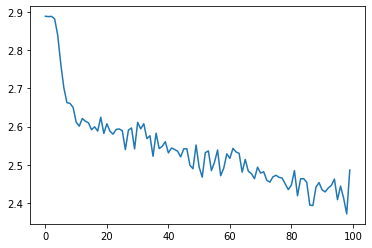

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# evaluate results

In [0]:
#create confusion matrix
confusion = torch.zeros(n_categories,n_categories)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.init_hidden()
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

for i in range(n_confusion):
  r_cat, r_line, category_tensor, line_tensor = random_category()
  output = evaluate(line_tensor)
  guess_index, guess = category_guess(output)
  category_index = all_categories.index(r_cat)
  confusion[category_index][guess_index] +=1